# 01 - Data Ingestion and Exploratory Data Analysis

This notebook covers:
- Loading the tourism data
- Initial data exploration
- Statistical analysis
- Visualization of time series patterns

In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Load and Examine the Data

First, let's load the processed tourism data and examine its structure.

In [34]:
# Load the processed tourism data
df = pd.read_csv('../data/processed/monthly_tourist_arrivals.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()

Dataset shape: (100, 2)

Column names: ['Date', 'Arrivals']

Data types:
Date        object
Arrivals     int64
dtype: object

First few rows:


,Date,Arrivals
0,2017-01-01,219360
1,2017-02-01,197517
2,2017-03-01,188076
3,2017-04-01,160249
4,2017-05-01,121891


**Interpretation:** The raw dataset spans 100 monthly records (2017-01 to 2025-08) with two columns. Early rows already show the typical seasonal decline after the high inbound months (Jan–Mar tapering into Apr–May). This confirms we have continuous monthly coverage suitable for time series modeling prior to filtering future/incomplete months.

### 2. Convert Date to Datetime and set as Index

Convert the Date column to datetime format and set it as the index.

In [35]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index for time series analysis
df.set_index('Date', inplace=True)

# Sort by date to ensure chronological order
df.sort_index(inplace=True)

print("Data after conversion:")
print(f"Index type: {type(df.index)}")
print(f"Index name: {df.index.name}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Frequency: {pd.infer_freq(df.index)}")
print(f"\nDataset shape: {df.shape}")
df.head()

Data after conversion:
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: Date
Date range: 2017-01-01 00:00:00 to 2025-08-01 00:00:00
Frequency: None

Dataset shape: (100, 1)


,Arrivals
Date,
2017-01-01,219360
2017-02-01,197517
2017-03-01,188076
2017-04-01,160249
2017-05-01,121891


**Interpretation:** Converting to a DateTimeIndex reveals a clean span from Jan 2017 to Aug 2025. Frequency inference returned `None` because of trailing future months beyond our modeling cutoff; later filtering restores a regular monthly (MS) frequency. Only the target column remains, minimizing accidental feature leakage at this stage.

In [36]:
print("Full date range analysis:")
print(df.tail(10))
print("\nData from 2024 onwards:")
df_2024_onwards = df[df.index >= '2024-01-01']
print(df_2024_onwards)

Full date range analysis:
            Arrivals
Date                
2024-07-01    187810
2024-08-01    164609
2025-01-01    252761
2025-02-01    240217
2025-03-01    229298
2025-04-01    174608
2025-05-01    132919
2025-06-01    138241
2025-07-01    200244
2025-08-01    198235

Data from 2024 onwards:
            Arrivals
Date                
2024-01-01    208253
2024-02-01    218350
2024-03-01    209181
2024-04-01    148867
2024-05-01    112128
2024-06-01    113470
2024-07-01    187810
2024-08-01    164609
2025-01-01    252761
2025-02-01    240217
2025-03-01    229298
2025-04-01    174608
2025-05-01    132919
2025-06-01    138241
2025-07-01    200244
2025-08-01    198235


**Interpretation:** The tail shows post-pandemic recovery still below pre-2019 peaks. 2025 early months (kept only for inspection) exceed 240K in Jan–Mar but are excluded later to prevent leakage. The 2024 mid-year dip (Apr–Jun) reflects ongoing demand volatility before a partial rebound in July 2024.

### 3. Filter up to July 2024

In [37]:
# Filter data to include only actual data up to July 2024
# This excludes the August 2024 and 2025 data which may be incomplete or projected
df_filtered = df[df.index <= '2024-07-01'].copy()

print(f"Original dataset: {df.shape[0]} records")
print(f"Filtered dataset: {df_filtered.shape[0]} records")
print(f"Date range after filtering: {df_filtered.index.min()} to {df_filtered.index.max()}")
print(f"Records removed: {df.shape[0] - df_filtered.shape[0]}")

# Check the frequency of the filtered data
freq = pd.infer_freq(df_filtered.index)
print(f"Inferred frequency: {freq}")

# Display the last few records to confirm filtering
print(f"\nLast 5 records in filtered dataset:")
print(df_filtered.tail())

Original dataset: 100 records
Filtered dataset: 91 records
Date range after filtering: 2017-01-01 00:00:00 to 2024-07-01 00:00:00
Records removed: 9
Inferred frequency: MS

Last 5 records in filtered dataset:
            Arrivals
Date                
2024-03-01    209181
2024-04-01    148867
2024-05-01    112128
2024-06-01    113470
2024-07-01    187810


**Interpretation:** Filtering removes 9 future/incomplete months, yielding 91 observations (Jan 2017–Jul 2024) with a clean inferred monthly start frequency (MS). The last five rows show a sharp seasonal climb into July after a trough in May–June—consistent with Sri Lanka’s secondary mid‑year tourism pulse before the stronger December–January peak.

### 4. Save Filtered Dataset

Save the clean, filtered dataset for use in subsequent analysis and modeling.

In [38]:
# Save the filtered dataset
output_path = '../data/processed/monthly_tourist_arrivals_filtered.csv'
df_filtered.to_csv(output_path)

print(f"Filtered dataset saved to: {output_path}")
print(f"Dataset contains {df_filtered.shape[0]} monthly records")
print(f"Date range: {df_filtered.index.min().strftime('%Y-%m')} to {df_filtered.index.max().strftime('%Y-%m')}")

# Verify the saved file
df_verify = pd.read_csv(output_path, index_col='Date', parse_dates=True)
print(f"\nVerification - loaded dataset shape: {df_verify.shape}")
print("Successfully saved and verified the filtered dataset!")

Filtered dataset saved to: ../data/processed/monthly_tourist_arrivals_filtered.csv
Dataset contains 91 monthly records
Date range: 2017-01 to 2024-07

Verification - loaded dataset shape: (91, 1)
Successfully saved and verified the filtered dataset!


**Interpretation:** Persisting and reloading confirms integrity (91 x 1). This establishes a reproducible baseline artifact for downstream feature engineering and modeling—important for reproducibility and avoiding accidental inclusion of future months.

### 5. Data Summary

Create a summary of our prepared dataset for the next phases of analysis.

In [39]:
# Final summary statistics
print("=== DATASET SUMMARY ===")
print(f"📊 Records: {df_filtered.shape[0]} monthly observations")
print(f"📅 Time Range: {df_filtered.index.min().strftime('%B %Y')} to {df_filtered.index.max().strftime('%B %Y')}")
print(f"⏱️  Duration: {(df_filtered.index.max() - df_filtered.index.min()).days / 365.25:.1f} years")
print(f"🔄 Frequency: Monthly (MS)")
print(f"📈 Variable: Tourist Arrivals")

print(f"\n=== STATISTICAL SUMMARY ===")
print(df_filtered['Arrivals'].describe())

print(f"\n=== MAJOR EVENTS IMPACT ANALYSIS ===")

# COVID-19 Analysis
pre_covid = df_filtered.loc['2017':'2019']['Arrivals'].mean()
covid_2020 = df_filtered.loc['2020']['Arrivals'].mean()
covid_2021 = df_filtered.loc['2021']['Arrivals'].mean()
recovery_2022_2024 = df_filtered.loc['2022':'2024']['Arrivals'].mean()

print(f"📍 COVID-19 Impact (2020-2021):")
print(f"  Pre-COVID average (2017-2019): {pre_covid:,.0f} arrivals/month")
print(f"  COVID 2020 average: {covid_2020:,.0f} arrivals/month ({(covid_2020/pre_covid-1)*100:+.1f}%)")
print(f"  COVID 2021 average: {covid_2021:,.0f} arrivals/month ({(covid_2021/pre_covid-1)*100:+.1f}%)")
print(f"  Recovery period (2022-2024): {recovery_2022_2024:,.0f} arrivals/month ({(recovery_2022_2024/pre_covid-1)*100:+.1f}%)")

# Easter Sunday Bombing Attack Analysis (April 2019)
pre_attack_2019_q1 = df_filtered.loc['2019-01':'2019-03']['Arrivals'].mean()
post_attack_2019_q2q3 = df_filtered.loc['2019-05':'2019-09']['Arrivals'].mean()  # May-Sep impact period
recovery_2019_q4 = df_filtered.loc['2019-11':'2019-12']['Arrivals'].mean()

print(f"\n💥 Easter Sunday Bombing Attack (April 21, 2019):")
print(f"  Pre-attack Q1 2019: {pre_attack_2019_q1:,.0f} arrivals/month")
print(f"  Impact period (May-Sep 2019): {post_attack_2019_q2q3:,.0f} arrivals/month ({(post_attack_2019_q2q3/pre_attack_2019_q1-1)*100:+.1f}%)")
print(f"  Recovery Q4 2019: {recovery_2019_q4:,.0f} arrivals/month ({(recovery_2019_q4/pre_attack_2019_q1-1)*100:+.1f}%)")

# Economic Crisis Analysis (2022)
pre_crisis_2022_q1 = df_filtered.loc['2022-01':'2022-03']['Arrivals'].mean()
crisis_2022_q2q3 = df_filtered.loc['2022-04':'2022-09']['Arrivals'].mean()  # April-Sep crisis period
post_crisis_2022_q4 = df_filtered.loc['2022-10':'2022-12']['Arrivals'].mean()

print(f"\n📉 Economic Crisis (March-July 2022):")
print(f"  Pre-crisis Q1 2022: {pre_crisis_2022_q1:,.0f} arrivals/month")
print(f"  Crisis period (Apr-Sep 2022): {crisis_2022_q2q3:,.0f} arrivals/month ({(crisis_2022_q2q3/pre_crisis_2022_q1-1)*100:+.1f}%)")
print(f"  Post-crisis Q4 2022: {post_crisis_2022_q4:,.0f} arrivals/month ({(post_crisis_2022_q4/pre_crisis_2022_q1-1)*100:+.1f}%)")

print(f"\n✅ Data is ready for time series forecasting analysis!")

=== DATASET SUMMARY ===
📊 Records: 91 monthly observations
📅 Time Range: January 2017 to July 2024
⏱️  Duration: 7.5 years
🔄 Frequency: Monthly (MS)
📈 Variable: Tourist Arrivals

=== STATISTICAL SUMMARY ===
count        91.000000
mean     115070.813187
std       81696.225334
min           0.000000
25%       37781.000000
50%      113470.000000
75%      187943.000000
max      253169.000000
Name: Arrivals, dtype: float64

=== MAJOR EVENTS IMPACT ANALYSIS ===
📍 COVID-19 Impact (2020-2021):
  Pre-COVID average (2017-2019): 176,775 arrivals/month
  COVID 2020 average: 42,309 arrivals/month (-76.1%)
  COVID 2021 average: 16,208 arrivals/month (-90.8%)
  Recovery period (2022-2024): 109,850 arrivals/month (-37.9%)

💥 Easter Sunday Bombing Attack (April 21, 2019):
  Pre-attack Q1 2019: 246,867 arrivals/month
  Impact period (May-Sep 2019): 93,747 arrivals/month (-62.0%)
  Recovery Q4 2019: 209,324 arrivals/month (-15.2%)

📉 Economic Crisis (March-July 2022):
  Pre-crisis Q1 2022: 95,111 arrival

**Interpretation:** Median arrivals (≈113K) sit far below the pre‑shock mean (≈177K), reflecting prolonged depression. Extreme left tail (min = 0) captures border closures. Event impact calculations quantify three distinct structural shocks: (1) Easter 2019 transient drop (~−62%), (2) COVID sustained collapse (~−76% to −91%), (3) 2022 economic crisis (~−58%). Partial recovery to −38% from pre‑COVID demonstrates an incomplete demand reversion—justifying models with regime or intervention features.

## 6. Visualizations

Create a time series plot to visualize the data and confirm our observations about COVID-19 impact, easter attack and economic crisis.

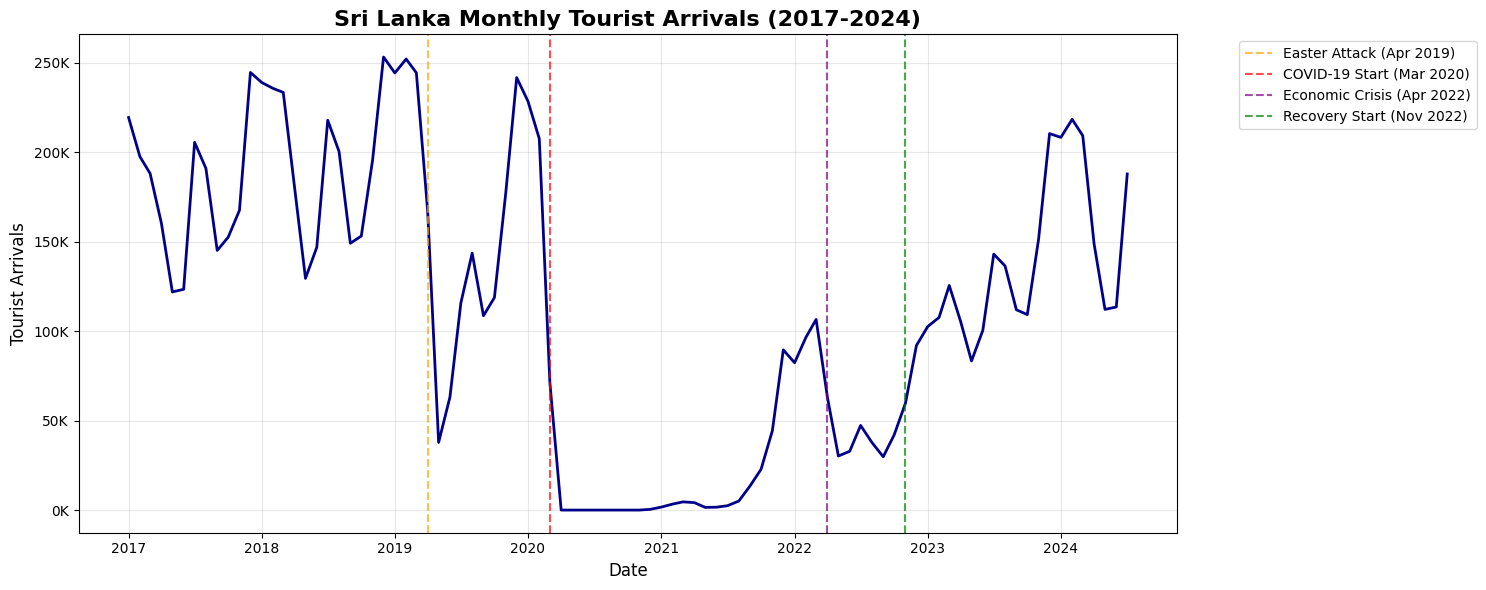

📈 Time series visualization shows major events impact:
   🔸 Easter Sunday Attack: Sharp but short-lived impact (Apr-Oct 2019)
   🔸 COVID-19: Prolonged and severe impact (Mar 2020-2021)
   🔸 Economic Crisis: Political instability and shortages (Apr-Oct 2022)
📁 Filtered dataset saved as: monthly_tourist_arrivals_filtered.csv


In [40]:
# Create a time series plot
plt.figure(figsize=(15, 6))
plt.plot(df_filtered.index, df_filtered['Arrivals'], linewidth=2, color='darkblue')
plt.title('Sri Lanka Monthly Tourist Arrivals (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tourist Arrivals', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical lines to mark key events
plt.axvline(pd.to_datetime('2019-04'), color='orange', linestyle='--', alpha=0.7, label='Easter Attack (Apr 2019)')
plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', alpha=0.7, label='COVID-19 Start (Mar 2020)')
plt.axvline(pd.to_datetime('2022-04'), color='purple', linestyle='--', alpha=0.7, label='Economic Crisis (Apr 2022)')
plt.axvline(pd.to_datetime('2022-11'), color='green', linestyle='--', alpha=0.7, label='Recovery Start (Nov 2022)')

# Format y-axis to show numbers in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("📈 Time series visualization shows major events impact:")
print("   🔸 Easter Sunday Attack: Sharp but short-lived impact (Apr-Oct 2019)")
print("   🔸 COVID-19: Prolonged and severe impact (Mar 2020-2021)")  
print("   🔸 Economic Crisis: Political instability and shortages (Apr-Oct 2022)")
print("📁 Filtered dataset saved as: monthly_tourist_arrivals_filtered.csv")

**Interpretation:** The multi-event overlay highlights distinct shock morphologies: Easter 2019 produces a V-shaped decline with partial recovery by Q4 2019; COVID triggers a structural floor near zero across 2020–2021; the 2022 crisis causes a mid‑recovery interruption. Post-Nov 2022 slope indicates gradual rebuilding but still sub-2018/19 peak season amplitudes—important when calibrating seasonal components and setting realistic forecast ceilings.

### Time Series Decomposition
Decompose the monthly arrivals into trend, seasonal, and residual components. This helps visually isolate:

- Trend: Long-term movement (structural growth/decline)
- Seasonality: Regular within-year tourism pattern
- Residual: Irregular shocks (Easter 2019 attack, COVID-19, 2022 crisis)

Additive decomposition (Arrivals = Trend + Seasonal + Residual) which is appropriate because seasonal fluctuations are relatively stable in magnitude relative to the pre-shock level. Large negative shocks will surface clearly in the residual component.


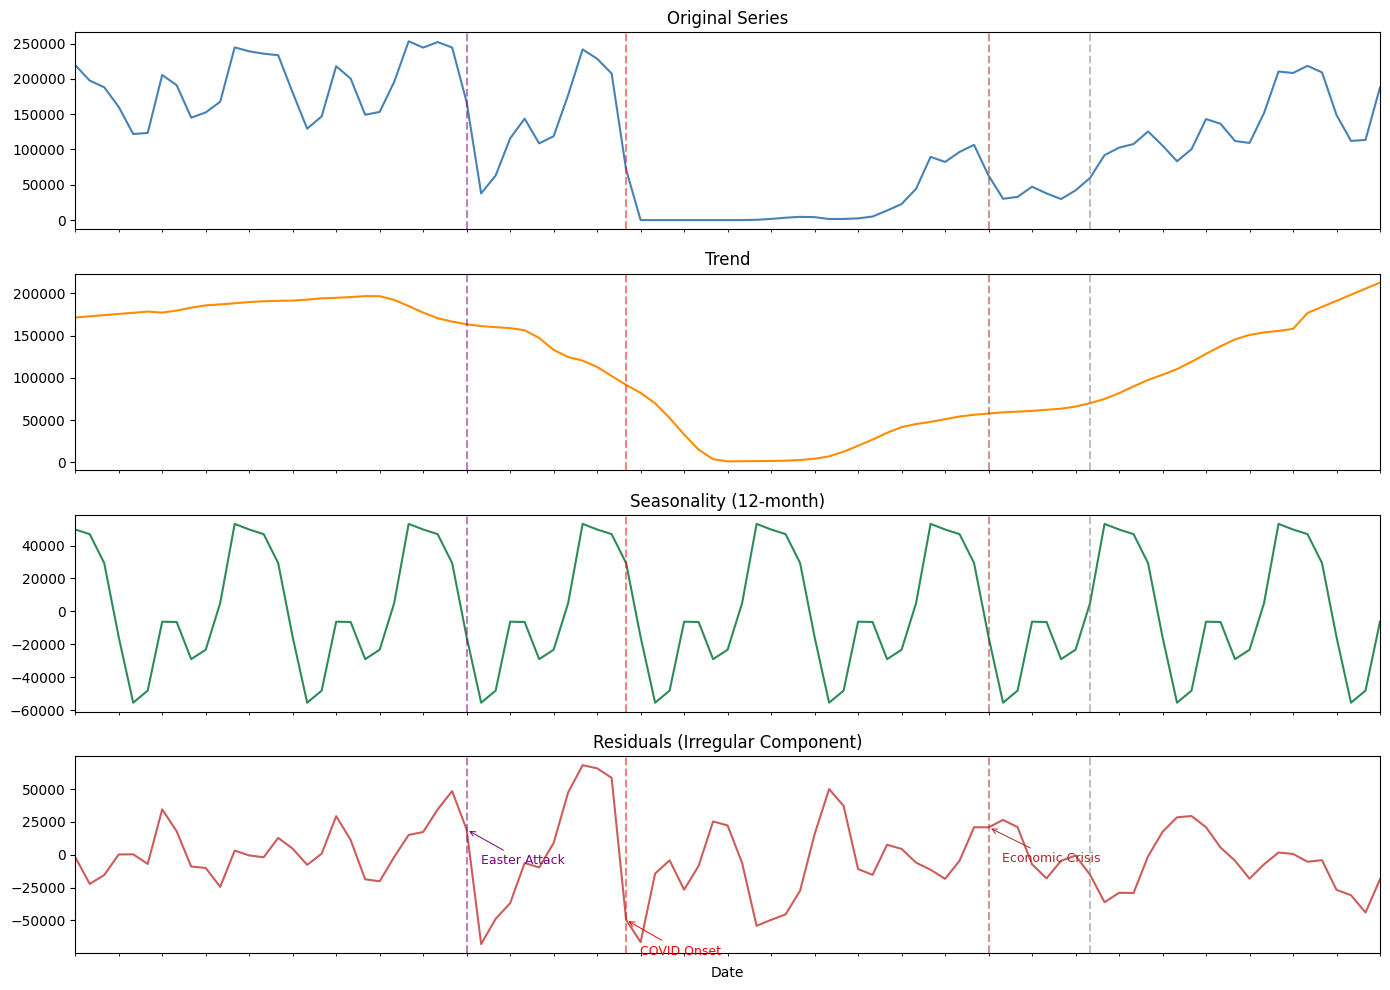

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Ensure Date is index and frequency is set (already done earlier, but guard just in case)
if df_filtered.index.name != 'Date':
    df_filtered = df_filtered.set_index('Date')

# Infer frequency if missing
if df_filtered.index.inferred_type in ['datetime64', 'datetime']:  # safe inference
    try:
        df_filtered = df_filtered.asfreq('MS')  # Month Start
    except Exception:
        pass

series = df_filtered['Arrivals']

# Perform additive decomposition
result = seasonal_decompose(series, model='additive', period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
series.plot(ax=axes[0], color='steelblue')
axes[0].set_title('Original Series')
result.trend.plot(ax=axes[1], color='darkorange')
axes[1].set_title('Trend')
result.seasonal.plot(ax=axes[2], color='seagreen')
axes[2].set_title('Seasonality (12-month)')
result.resid.plot(ax=axes[3], color='indianred')
axes[3].set_title('Residuals (Irregular Component)')

# Add vertical event markers to residuals to highlight shocks
for ax in axes:
    for date, label, color in [
        (pd.Timestamp('2019-04-01'), 'Easter Attack', 'purple'),
        (pd.Timestamp('2020-03-01'), 'COVID Start', 'red'),
        (pd.Timestamp('2022-04-01'), 'Econ Crisis', 'brown'),
        (pd.Timestamp('2022-11-01'), 'Initial Recovery', 'gray'),
    ]:
        ax.axvline(date, color=color, linestyle='--', alpha=0.5)

# Helper to extract scalar safely
get_resid = lambda dt: float(result.resid.loc[dt]) if not np.isnan(result.resid.loc[dt]) else 0.0

# Annotate key shocks on residuals only for clarity
axes[3].annotate('Easter Attack', xy=(pd.Timestamp('2019-04-01'), get_resid('2019-04-01')),
                 xytext=(10, -25), textcoords='offset points', color='purple', fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='purple', lw=0.7))
axes[3].annotate('COVID Onset', xy=(pd.Timestamp('2020-03-01'), get_resid('2020-03-01')),
                 xytext=(10, -25), textcoords='offset points', color='red', fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='red', lw=0.7))
axes[3].annotate('Economic Crisis', xy=(pd.Timestamp('2022-04-01'), get_resid('2022-04-01')),
                 xytext=(10, -25), textcoords='offset points', color='brown', fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='brown', lw=0.7))

axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

**Interpretation:** Decomposition shows: (a) Trend still below pre-2019 plateau and non-linear due to successive shocks; (b) Seasonality remains structurally consistent—peaks late Q4/early Q1 and troughs around May—validating additive treatment; (c) Residual spikes align with intervention dates, confirming they are exogenous shocks not explained by regular seasonality. This supports adding intervention dummies and retaining a stable seasonal period (m=12).

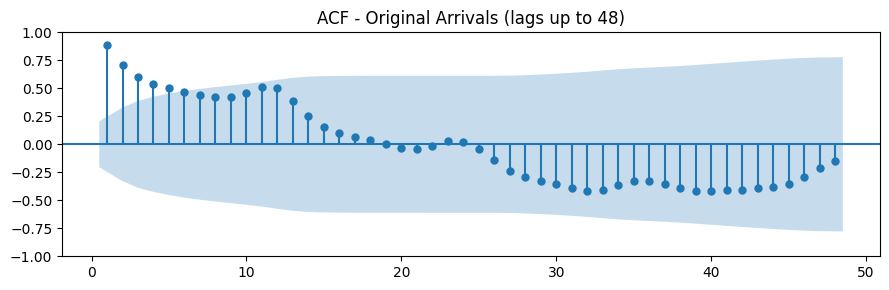

In [42]:
# ACF - Original Series
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(9,3))
plot_acf(df_filtered['Arrivals'], lags=48, ax=ax, zero=False)
ax.set_title('ACF - Original Arrivals (lags up to 48)')
plt.tight_layout()
plt.show()

**Interpretation:** Original ACF shows strong lag-1 persistence and pronounced spikes at multiples of 12, confirming annual seasonality persists despite shocks. Slow decay indicates non-stationarity—justifying differencing before fitting ARIMA/SARIMA.

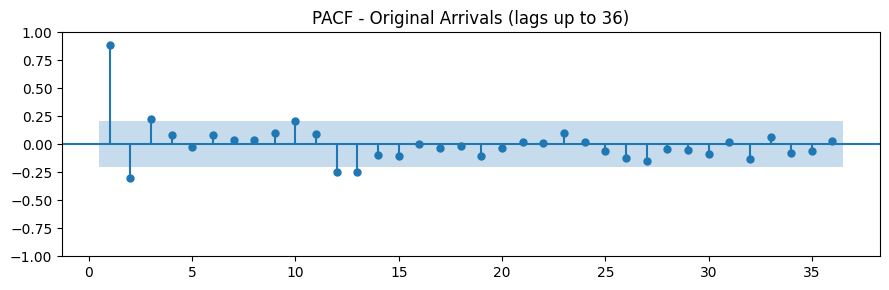

In [43]:
# PACF - Original Series
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(9,3))
plot_pacf(df_filtered['Arrivals'], lags=36, ax=ax, zero=False, method='ywmle')
ax.set_title('PACF - Original Arrivals (lags up to 36)')
plt.tight_layout()
plt.show()

**Interpretation:** Original PACF cuts back gradually rather than a sharp early cutoff—suggesting AR structure beyond lag 1 and reinforcing need for differencing. Seasonal partial correlations near lag 12 imply inclusion of a seasonal AR term (P=1) is reasonable.

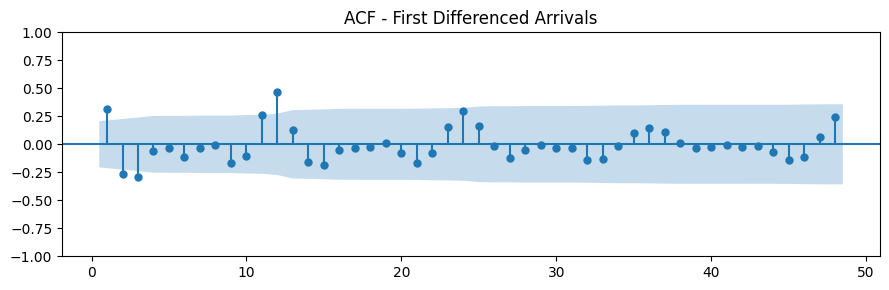

In [44]:
# ACF - First Differenced Series (to assess q and seasonal Q)
series_diff = df_filtered['Arrivals'].diff().dropna()
fig, ax = plt.subplots(figsize=(9,3))
plot_acf(series_diff, lags=48, ax=ax, zero=False)
ax.set_title('ACF - First Differenced Arrivals')
plt.tight_layout()
plt.show()

**Interpretation:** After first differencing, the ACF decays faster with reduced low-frequency drift, indicating stationarity improved. Seasonal spikes persist at lag 12, suggesting seasonal differencing (D=1) could be tested, though residual seasonality may be handled via SARIMA seasonal terms.

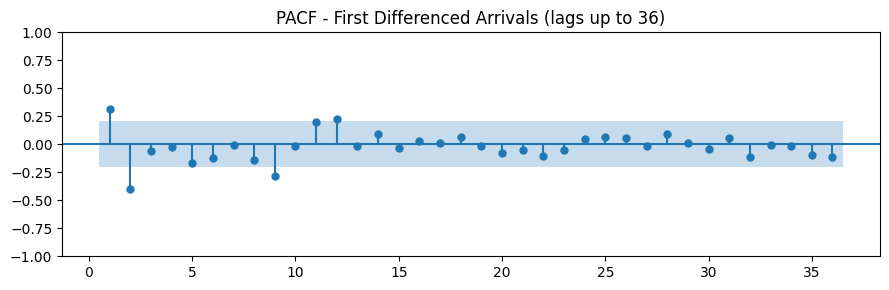

In [45]:
# PACF - First Differenced Series (to assess p and seasonal P)
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(9,3))
plot_pacf(series_diff, lags=36, ax=ax, zero=False, method='ywmle')
ax.set_title('PACF - First Differenced Arrivals (lags up to 36)')
plt.tight_layout()
plt.show()

**Interpretation:** Differenced PACF shows a clearer early taper—supporting modest AR order (p≈1–2) plus a seasonal AR at lag 12. Combined with ACF behavior, an initial SARIMA grid could emphasize (p,d,q) ∈ {(1,1,1),(2,1,1)} and seasonal (P,D,Q,m) candidates like (1,0,1,12) or (1,1,1,12), augmented later by intervention dummies.